# Projeto Spark

Entrega: 31 de maio de 2023

## Introdução

Neste projeto vamos construir um classificador Naive-Bayes para determinar o sentimento de um comentário.

## Grupos

O projeto pode ser individual ou em duplas. Criem os grupos em https://classroom.github.com/a/EdbpYF9x

## Instalando o ambiente

O jeito mais simples de começar a trabalhar com Spark é instalar um container com tudo pronto! No site https://hub.docker.com/r/jupyter/pyspark-notebook vemos uma imagem Docker que já vem com `pyspark` e `jupyter lab`. Instale a imagem com o comando:

```bash
docker pull jupyter/pyspark-notebook
```

Vamos iniciar o ambiente de trabalho com o comando `docker run`. Para isso precisamos tomar alguns cuidados:

1) Temos que mapear nosso diretorio local de trabalho para um diretório interno do container, de modo que alterações feitas dentro do container (nesta pasta escolhida) sejam gravadas no nosso diretorio local. No container temos um usuário padrão com *username* `jovyan`. No *homedir* desse usuario temos uma pasta vazia `work`, que vai servir como local de mapeamento do nosso diretorio local de trabalho. Podemos então fazer esse mapeamendo com a opção `-v` do comando `docker run` da seguinte forma:

```bash
-v <diretorio>:/home/jovyan/work
```

onde `<diretorio>` representa seu diretorio local de trabalho.

2) Para acessar o `jupyter notebook` e o *dashboard* do Spark a partir do nosso *browser* favorito temos que abrir algumas portas do container com a opção `-p`. As portas são `8888` (para o próprio `jupyter notebook`) e `4040` (para o *dashboard* do Spark). Ou seja, adicionaremos às opções do `docker run`o seguinte:

```bash
-p 8888:8888 -p 4040:4040
```

Desta forma, ao acessar `localhost:8888` na nossa máquina, estaremos acessando o servidor Jupyter na porta 8888 interna do container.

3) Vamos iniciar o container no modo interativo, e vamos especificar que o container deve ser encerrado ao fechar o servidor Jupyter. Faremos isso com as opções `-it` e `-rm`

Portanto, o comando completo que eu uso na minha máquina Linux para iniciar o container é:

```bash
docker run \
    -it \
    --rm \
    -p 8888:8888 \
    -p 4040:4040 \
    -v "`pwd`":/home/jovyan/work \
    jupyter/pyspark-notebook
```

Para facilitar a vida eu coloco esse comando em um arquivo `inicia.sh`. Engenheiros, façam do jeito que preferirem!

Agora abra esse notebook lá no container!


## Iniciando o Spark

Vamos iniciar o ambiente Spark. Para isso vamos:

1) Criar um objeto de configuração do ambiente Spark. Nossa configuração será simples: vamos especificar que o nome da nossa aplicação Spark é "Minha aplicação", e que o *master node* é a máquina local, usando todos os *cores* disponíveis. Aplicações reais de Spark são configuradas de modo ligeiramente diferente: ao especificar o *master node* passamos uma URL real, com o endereço do nó gerente do *cluster* Spark.

2) Vamos criar um objeto do tipo `SparkContext` com essa configuração

In [5]:
import pyspark

conf = pyspark.SparkConf()
conf.setAppName('Minha aplicação')
conf.setMaster('local[*]')

sc = pyspark.SparkContext(conf=conf)

O `SparkContext` é a nossa porta de entrada para o cluster Spark, ele será a raiz de todas as nossas operações com o Spark.

In [6]:
sc

<SparkContext master=local[*] appName=Minha aplicação>

O link acima provavelmente não funcionará porque ele se refere à porta 4040 interna do container (portanto a URL está com endereço interno). Porém fizemos o mapeamento da porta 4040 interna para a porta 4040 externa, logo você pode acessar o *dashboard* do Spark no endereço http://localhost:4040

<center><img src="./spark_dashboard.png" width=800/></center>

## Lendo os dados

Vamos começar lendo o arquivo de reviews e gravando o resultado em formato pickle, mais amigável.

Agora vamos gravar no formato pickle, para facilitar os trabalhos futuros. Após gravar o arquivo, não mais rode as células desta primeira etapa!

## Um classificador Naive-Bayes

Vamos ler o arquivo pickle gravado anteriormente:

In [7]:
rdd = sc.pickleFile('reviews.pickle')

In [8]:
rdd.count()

3600000

In [9]:
rdd.take(1)

[(1,
  'half a book',
  "I recently purchased this book along with the set of cassettes. It turns out, however, that the book is only part II of the complete course. This isn't mentioned anywhere in the course description. The cassettes, however, cover the complete course, so that only the last three cassettes correspond to part II. In order to make use of the course and all the cassettes, you'd have to purchase the teacher's manual, which isn't available on amazon.com. Otherwise, the course looks to quite good.")]

Agora, complete as tarefas em sequencia para construir o classificador Naive-Bayes:

### Fase 1

#### Tarefa

Construa uma função que recebe um RDD no formato do RDD original e retorna um RDD no qual cada item é um par (palavra, contagem).

In [10]:
import re
import string

In [11]:
def limpa_pontuacao(sentence):
    punctuation = f'[{string.punctuation}]'  # Regex pontuação
    pattern = re.compile(punctuation)        # Padrões
    text_subbed = re.sub(pattern, '', sentence)  # Substitui pontuacao por vazio
    return text_subbed

def pega_palavra(line):
    titulo   = line[1]
    corpo    = line[2]
    sentence = titulo + " " + corpo

    # Retira pontuações
    sentence = limpa_pontuacao(sentence)
    palavras = sentence.lower().split(" ")

    return palavras

In [12]:
rdd \
    .filter(lambda x: x[2]) \
    .flatMap(pega_palavra) \
    .take(2)

['half', 'a']

In [13]:
# verifica se titulo + body != vazio
# Retorna palavras de forma individual
def return_palavra_contagem(rdd):
    return rdd \
        .filter(lambda x: x[2]) \
        .flatMap(pega_palavra) \
        .map(lambda palavra : (palavra, 1)) \
        .reduceByKey(lambda x, y: x + y)

In [14]:
rdd_palavras = return_palavra_contagem(rdd)
rdd_palavras.take(1)

[('book', 1926144)]

#### Tarefa

Construa uma função que recebe o RDD (palavra, contagem) construido anteriormente e retorna um RDD no qual cada item é um par (palavra, $\log_{10}\left(c \, / \, T\right)$), onde $c$ é a contagem daquela palavra e $T$ é a soma das contagens de palavra.

In [16]:
import numpy as np

In [17]:
def return_palavra_log(rdd):
    T = rdd\
    .map(lambda tupla : tupla[1])\
    .sum()
    
    return rdd \
        .map(lambda tupla : (tupla[0] , np.log(tupla[1]/T)))

In [18]:
rdd_palavra_log = return_palavra_log(rdd_palavras)
rdd_palavra_log.take(1)

[('book', -4.988107155519375)]

#### Tarefa

Separe o RDD original em dois RDDs: o dos reviews positivos e o dos negativos. Em seguida, use as funções anteriores para construir RDDs que contem os pares (palavra, $\log_{10}\left(c \, / \, T\right)$)

In [19]:
rdd_positivo = rdd.filter(lambda x: x[0] == 2)
rdd_negativo = rdd.filter(lambda x: x[0] == 1)

In [20]:
rdd_positivo_contagem = return_palavra_contagem(rdd_positivo)
rdd_negativo_contagem = return_palavra_contagem(rdd_negativo)

In [21]:
rdd_palavra_log_positivo = return_palavra_log(rdd_positivo_contagem)
rdd_palavra_log_negativo = return_palavra_log(rdd_negativo_contagem)

In [22]:
rdd_palavra_log_positivo.take(1)

[('book', -4.911103411248069)]

In [23]:
rdd_palavra_log_negativo.take(1)

[('book', -5.065096910869075)]

### Tarefa

Use o `.fullOuterJoin()` dos RDDs para construir um RDD unificado, no qual cada item é da forma (palavra, log_prob_positivo, log_prob_negativo). "Baixe" esse resultado final usando `.collect()`.

In [24]:
rdd_unificado = rdd_palavra_log_positivo\
                .fullOuterJoin(rdd_palavra_log_negativo)\
                .map(lambda tupla : (tupla[0] , tupla[1][0], tupla[1][1]))

In [25]:
palavras_e_probabilidades = rdd_unificado.collect()

#### Tarefa

Para uma dada string, determine se ela é um review positivo ou negativo usando os RDDs acima. Lembre-se de como funciona o classificador Naive-Bayes: http://stanford.edu/~jurafsky/slp3/slides/7_NB.pdf, consulte tambem suas notas de aula de Ciência dos Dados!

In [26]:
dic_palavra_prob = {}

for palavra , p_positiva , p_negativa in palavras_e_probabilidades:
    dic_palavra_prob[palavra] = (p_positiva , p_negativa)

In [27]:
# P(palavra | feedback) * P(feedback) = P(feedback | palavra) * P(palavra)
# P(feedback | palavra) = P(palavra | feedback) * P(feedback) / P(palavra)

def classifica_texto(texto):
    texto = limpa_pontuacao(texto).lower()

    count_prob_positiva = 0   # Soma probabilidades positivas das palavras na frase
    count_prob_negativa = 0   # Soma probabilidades negativas das palavras na frase

    for palavra in texto.split(" "):
        prob = dic_palavra_prob.get(palavra)
        if prob is not None:
            count_prob_positiva += prob[0] if prob[0] is not None else 0
            count_prob_negativa += prob[1] if prob[1] is not None else 0

    return (2 if count_prob_positiva > count_prob_negativa else 1 , count_prob_positiva , count_prob_negativa)

In [28]:
classifica_texto("What a bad day!")

(1, -24.674957722010035, -23.609502203522567)

In [29]:
classifica_texto("What a good day!")

(2, -22.450374133226827, -22.972002957044637)

### Fase 2

Agora que temos um classificador Naive-Bayes, vamos explorá-lo um pouco:

### Tarefa

Quais são as 100 palavras que mais indicam negatividade, ou seja, onde a diferença entre a probabilidade da palavra no conjunto dos comentários negativos e positivos é máxima? E quais as 100 palavras de maior positividade? Mostre os resultados na forma de *word clouds*.

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

In [44]:
df_palavras_prob = pd.DataFrame(palavras_e_probabilidades, columns=['palavra', 'prob_positiva', 'prob_negativa'])

# Cria coluna de diferença entre probabilidades
df_palavras_prob["dif_prob"] = df_palavras_prob['prob_positiva'] - df_palavras_prob['prob_negativa']

df_palavras_prob.head(2)

,palavra,prob_positiva,prob_negativa,dif_prob
0,start,-8.024559,-8.228067,0.203508
1,nights,-10.351719,-10.958419,0.606701


In [45]:
# quanto maior o dif maior a chance de ser negativo

# Ordenando os valores de diff de ordem crescente para pegar os 100 MAIS NEGATIVOS
top_100_palavras_negativas = df_palavras_prob.sort_values(by='dif_prob' , ascending=True).iloc[:100]['palavra'].values
top_100_palavras_negativas

array(['securom', 'zerostar', 'dullsville', 'e18', 'cdilla', 'junkdont',
       'itsave', 'unprofessionally', 'nonreturnable', 'boooooo', 'purile',
       'junkit', 'wost', 'bellesiles', 'awfulit', 'refundable',
       'garbageif', 'garbagedont', 'insultingly', 'klone', 'refundthe',
       'booooring', 'c82', 'itstay', 'userunfriendly', 'boringdont',
       'nabu', 'lousiest', 'iolo', 'unengaging', 'unwearable',
       'characterless', 'pseudohistory', 'moneydo', 'uselessif',
       'zzzzzzzzzz', 'refundi', 'crapdont', 'horribleif', 'boooooring',
       'booooo', 'sloooooow', 'nonsensei', 'hackwork', 'untoasted',
       'liveupdate', 'restocking', 'zzzzzzzzzzz', 'actingbad', 'suckthey',
       'regnery', 'snoozefest', 'viavoice', 'unacceptablei', 'marginmart',
       'salvagable', 'unenlightening', 'ilok', 'refundthis', 'overcooks',
       'overgeneralized', 'allsave', 'uggg', 'ughh', 'warrantly',
       'benzoate', 'zzzzzzz', 'uninvolving', 'horrble', 'awfuljust',
       'extenderthe'

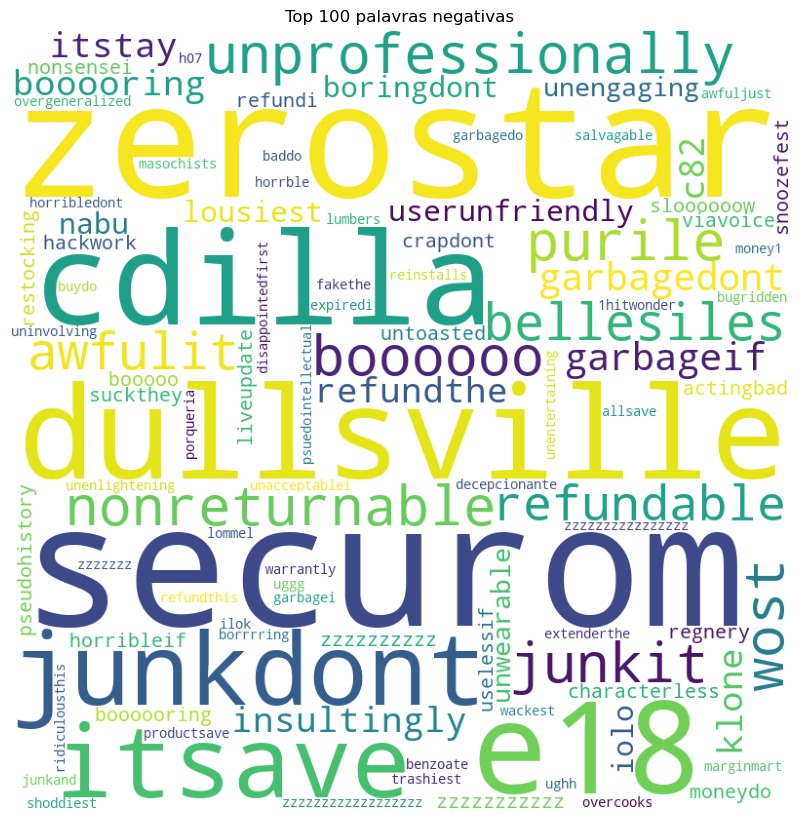

In [46]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(' '.join(top_100_palavras_negativas))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Top 100 palavras negativas')
plt.tight_layout(pad = 0)
 
plt.show()

In [47]:
# Ordenando os valores de diff de ordem decrescente para pegar os 100 MAIS POSITIVOS
top_100_palavras_positivas = df_palavras_prob.sort_values(by='dif_prob' , ascending=False).iloc[:100]['palavra'].values
top_100_palavras_positivas

array(['getabstract', 'awesomest', 'magnifique', 'collaboratively',
       'timehighly', 'wellhighly', 'infectiously', 'amust', 'title1',
       'ministered', 'alsome', 'buenisimo', 'fireheart', 'versital',
       'espectacular', 'mcvay', 'total1', 'moregreat', 'jazzs',
       'plainspoken', 'bookhighly', 'horan', 'extraordinario', 'bestkept',
       'heroscape', 'cimorene', 'soundgreat', 'nonintimidating',
       'rivoting', 'mustlisten', 'lifegreat', 'longheld', 'corfu',
       'recommendeda', 'incedible', 'thunderclan', 'fantistic',
       'wunderbar', 'funfunfun', 'pricethank', 'liesel', 'elfangor',
       'exelente', 'songsgreat', 'awesomea', 'kora', 'mustbuy',
       'evergreat', 'greatgreatgreat', 'epicness', 'masterstroke',
       'beautifullythe', 'infectous', '10103', '10109', '910the',
       'musthave', 'mustget', 'endgreat', 'owly', 'pricelessi',
       'redwalls', 'wonderfulin', 'musthear', 'cameronsmith',
       'pitchperfect', '6314', 'digno', 'finntroll', 'intro2',
   

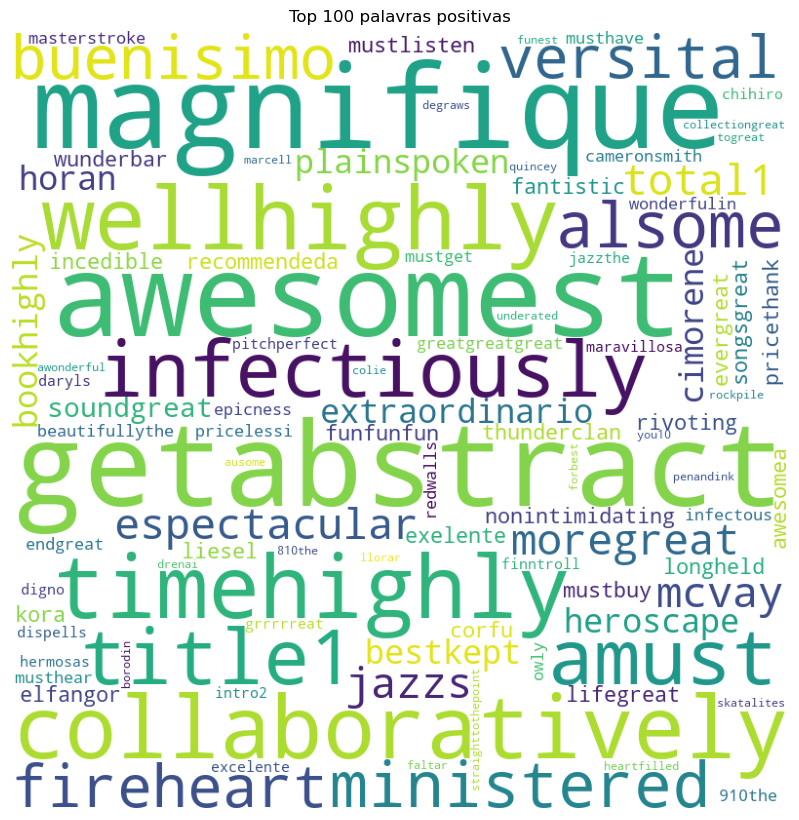

In [48]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(' '.join(top_100_palavras_positivas))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Top 100 palavras positivas')
plt.tight_layout(pad = 0)
 
plt.show()

### Tarefa desafio!

Qual o desempenho do classificador (acurácia)? Para medir sua acurácia:

- Separe os reviews em dois conjuntos: treinamente e teste
- Repita o "treinamento" do classificador com o conjunto de treinamento
- Para cada review do conjunto de teste, determine se é positiva ou negativa de acordo com o classificador
- Determine a acurácia

Esta não é uma tarefa trivial. Não basta fazer um `for` para determinar a classe de cada review de teste: isso demoraria uma eternidade. Você tem que usar variáveis "broadcast" do Spark para enviar uma cópia da tabela de frequencias para cada *core* do executor.

### Tarefa desafio!

Implemente Laplace smoothing

## Rubrica de avaliação

- I: groselha, falha crítica, ou não entregou nada
- D: Fez uma tentativa honesta de fazer todos os itens da fase 1, mas tem erros
- C: Fase 1 completa
- B: Fase 2, faltando apenas um desafio
- A: Fase 2 completa